In [ ]:
#Simulador AER fecha 07/04/2025

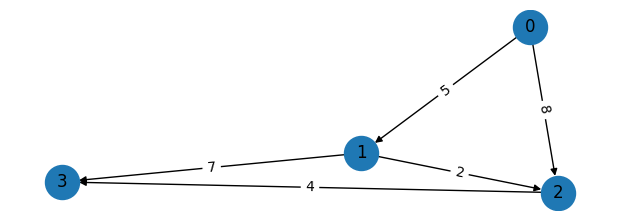

Parámetros óptimos: [0.97178428 0.99406302 1.01391187 1.00679929 0.99398492 1.0150907 ]
Soluciones ordenadas por coste:
10101: 11
01001: 12
10010: 12
00000: 27
00001: 32
00101: 34
00010: 35
11001: 43
11101: 45
11010: 46
11011: 51
10000: 58
10100: 60
01000: 61
10001: 63
01101: 68
10110: 68
01010: 69
10011: 71
10111: 73
01011: 74
00100: 83
11000: 92
00011: 94
11111: 107
00110: 145
11100: 148
00111: 150
11110: 156
01100: 171
01111: 184
01110: 233


In [37]:
from scipy.optimize import minimize
import itertools
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, List, Tuple
import networkx as nx
import time

# Grafo
edges = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
num_nodes = 4

# Coeficientes lineales y cuadráticos del Hamiltoniano 
linear_coefs = [11, -17.5, -28, -17, 11.5]
quadra_coefs = {
    (0, 1): 13.5, (0, 2): -13.5, (0, 3): -13.5,
    (1, 2): 13.5, (1, 4): -13.5,
    (2, 3): 13.5, (2, 4): -13.5
}

# Función para imprimir el grafo dirigido con pesos
def print_graph(graph_nodes, graph_edges, layout=None):
    G = nx.DiGraph()
    G.add_nodes_from(graph_nodes)
    for (i, j), w in graph_edges.items():
        G.add_edge(i, j, weight=w)

    if layout is None:
        layout = nx.spring_layout(G)
    plt.figure(figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)
    plt.show()

print_graph(range(num_nodes), edges)

# Función de coste expresada como string
cost_function = "\
5*x_01 + 8*x_02 + 2*x_12 + 7*x_13 + 4*x_23 + \
27*(x_01 + x_02 - 1)**2 + \
27*(x_01 - x_12 - x_13)**2 + \
27*(x_02 + x_12 - x_23)**2"

# Evalúa la función de coste para una solución concreta representada por bitstring
def eval_cost_function(bits: str) -> float:
    assert len(edges) == len(bits), "Error en longitud de bits"
    inv_bits = bits[::-1]  # Invertimos porque los qubits están en orden inverso
    param_dict = {}
    for n, (i, j) in enumerate(edges):
        param_dict[f"x_{i}{j}"] = int(inv_bits[n])
    return eval(cost_function, param_dict)

# Genera el circuito QAOA 
def generate_qaoa_circuit(theta: List[float]) -> QuantumCircuit:
    assert len(theta) % 2 == 0, "Theta debe tener número par de elementos"
    nqubits = len(linear_coefs) 
    circuit = QuantumCircuit(nqubits)
    layers = len(theta) // 2
    beta = theta[:layers]
    gamma = theta[layers:]

    # Estado inicial
    for i in range(nqubits):
        circuit.h(i)

    for p in range(layers):
        circuit.barrier()
        # Aplicar Rz según coeficientes lineales
        for q_idx, coef in enumerate(linear_coefs):
            circuit.rz(coef * 2 * gamma[p], q_idx)
        # Aplicar RZZ según coeficientes cuadráticos
        for (q0, q1), coef in quadra_coefs.items():
            circuit.rzz(coef * 2 * gamma[p], q0, q1)

        circuit.barrier()
        # Mezclador Rx con beta
        for q_idx in range(nqubits):
            circuit.rx(2 * beta[p], q_idx)

    circuit.measure_all()
    return circuit

# Calcula el valor esperado de la función de coste a partir de los resultados de medición
def compute_expectation(counts: dict) -> float:
    total = 0
    total_counts = 0
    for bits, count in counts.items():
        cost = eval_cost_function(bits)
        total += cost * count
        total_counts += count
    return total / total_counts


# Inicializamos el simulador y parámetros
simulator = AerSimulator()
shots = 2048
GRAPH_NAME = "QAOA"

# Función para ejecutar el circuito QAOA y calcular expectativa
def execute_circuit(theta: List[float]) -> float:
    qc = generate_qaoa_circuit(theta)
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return compute_expectation(counts)

# Optimización de parámetros usando COBYLA
num_layers = 3
initial_theta = [1.0] * num_layers + [1.0] * num_layers
theta_res = minimize(execute_circuit, initial_theta, method="COBYLA")

print("Parámetros óptimos:", theta_res.x)

# Ejecutamos circuito final con los parámetros óptimos
qc_opt = generate_qaoa_circuit(theta_res.x)
compiled_circuit = transpile(qc_opt, simulator)
start_time = time.time()
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()
end_time = time.time()
counts = result.get_counts()

# Mostrar todas las soluciones posibles ordenadas por coste
results = {}
for z in itertools.product(["0", "1"], repeat=len(edges)):
    z_str = ''.join(z)
    results[z_str] = eval_cost_function(z_str)

results_sorted = dict(sorted(results.items(), key=lambda item: item[1]))
print("Soluciones ordenadas por coste:")
for sol, val in results_sorted.items():
    print(f"{sol}: {val}")

plot_histogram(counts, figsize=(9, 4), title=GRAPH_NAME)


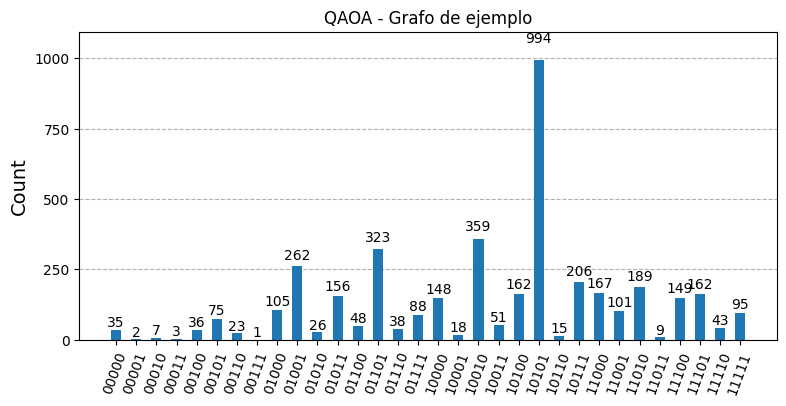

In [38]:
plot_histogram(counts, figsize=(9, 4), title=GRAPH_NAME)

In [39]:
print(counts)

{'00111': 1, '00011': 3, '11101': 162, '01011': 156, '10101': 994, '10010': 359, '11100': 149, '11000': 167, '11010': 189, '00101': 75, '01001': 262, '10001': 18, '01111': 88, '00001': 2, '00110': 23, '01101': 323, '10110': 15, '10111': 206, '10100': 162, '10000': 148, '11111': 95, '11011': 9, '11110': 43, '11001': 101, '00000': 35, '01010': 26, '01110': 38, '10011': 51, '00100': 36, '01000': 105, '01100': 48, '00010': 7}


In [42]:
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from itertools import product

# Solución óptima
opt_solution = ('1', '0', '1', '0', '1')  
opt_value = 11
shots = 4096

# Tiempo por muestra en milisegundos
t_total = end_time - start_time
t_sample = (t_total * 1000) / shots  

# Convertimos el diccionario counts en formato {'bitstring': count} a {tuple: count}
count_dict = {tuple(bits): c for bits, c in counts.items()}

# Calcular P_GS y TTS
def calculate_P_GS_and_TTS(count_dict, opt_states, t_sample):
    success_counts = sum(count_dict.get(state, 0) for state in opt_states)
    total_counts = sum(count_dict.values())
    p_gs = success_counts / total_counts

    if p_gs == 1.0:
        tts = t_sample
    elif p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * (np.log(1 - 0.99) / np.log(1 - p_gs))
    return p_gs, tts

# Puede haber múltiples bitstrings con coste mínimo
min_cost = min(eval_cost_function(''.join(bits)) for bits in count_dict)
opt_states = [bits for bits in count_dict if eval_cost_function(''.join(bits)) == min_cost]

# Métricas
p_gs, tts = calculate_P_GS_and_TTS(count_dict, opt_states, t_sample)

# Mostrar tabla de conteo de combinaciones observadas
print("\nConteo de todas las combinaciones:")
table_data = [[bits, count] for bits, count in sorted(count_dict.items(), key=lambda x: -x[1])]
print(tabulate(table_data, headers=["Combinación", "Conteo"], tablefmt="pretty"))

# Mostrar métricas
print("\nMétricas:")
print(f"P_GS: {p_gs:.4f}")
print(f"t_sample: {t_sample:.4f} ms")
print(f"TTS: {tts:.2f} ms")

# Tabla resumen
df = pd.DataFrame({
    "Instance": ["(QAOA AerSimulator)"],
    "Opt": [opt_value],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})
print("\nTabla de métricas:")
display(df)



Conteo de todas las combinaciones:
+---------------------------+--------+
|        Combinación        | Conteo |
+---------------------------+--------+
| ('1', '0', '1', '0', '1') |  999   |
| ('0', '1', '1', '0', '1') |  362   |
| ('1', '0', '0', '1', '0') |  334   |
| ('0', '1', '0', '0', '1') |  260   |
| ('1', '0', '1', '1', '1') |  228   |
| ('0', '1', '0', '1', '1') |  182   |
| ('1', '1', '0', '1', '0') |  173   |
| ('1', '0', '1', '0', '0') |  167   |
| ('1', '1', '1', '0', '1') |  165   |
| ('1', '0', '0', '0', '0') |  152   |
| ('1', '1', '0', '0', '1') |  134   |
| ('1', '1', '1', '0', '0') |  129   |
| ('1', '1', '0', '0', '0') |  120   |
| ('0', '1', '0', '0', '0') |  118   |
| ('1', '1', '1', '1', '1') |   73   |
| ('0', '1', '1', '1', '1') |   71   |
| ('0', '0', '1', '0', '1') |   70   |
| ('1', '1', '1', '1', '0') |   66   |
| ('1', '0', '0', '1', '1') |   39   |
| ('0', '1', '1', '1', '0') |   38   |
| ('0', '0', '0', '0', '0') |   33   |
| ('0', '1', '0', '1', '0') 

,Instance,Opt,P_GS,t_sample (ms),TTS (ms)
0,(QAOA AerSimulator),11,0.243896,0.001507,0.024817
